Realizar os imports:

In [26]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization, Flatten, Dense
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

Selecionar as features:

In [49]:
feature_method = "aug_rms"
dataset = pd.read_csv(f'./features/emoUERJ_features/{feature_method}_features.csv')
result_folder = f'./results/{feature_method}/'

Formatar os dados:

In [50]:
num_classes = 4

dataset = dataset.iloc[:,1:]
X = dataset.drop('label', axis=1)  # Features  # Features
# Create a LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the "label" column
y = label_encoder.fit_transform(dataset["label"])

text_labels = label_encoder.classes_
encoded_to_class_mapping = dict(zip(label_encoder.transform(text_labels), text_labels))
print("Classes codificadas:" + str(encoded_to_class_mapping))

# Preprocess Data (example: standardizing numerical features)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# # Adjust sequence_length and input_dim based on your actual data
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define the number of folds
num_folds = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)


Classes codificadas:{0: 'felicidade', 1: 'neutro', 2: 'raiva', 3: 'tristeza'}


Escolher a arquitetura:

In [38]:
# ### My architecture
def create_model():
    # Define the model
    model = Sequential()
    # Convolutional layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X.shape[1:]))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    # Flatten layer
    model.add(Flatten())
    # Dense layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))  # Replace 'num_classes' with the number of output classes
    return model

# keras.utils.plot_model(model, show_shapes=True)


In [ ]:

## Paper architecture (Overfitting)
def create_model():
    # Define the model
    model = Sequential()
    # Convolutional layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X.shape[1:]))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    # Flatten layer
    model.add(Flatten())
    # Dense layers
    model.add(Dense(64, activation='relu'))
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))  # Replace 'num_classes' with the number of output classes
    return model

# keras.utils.plot_model(model, show_shapes=True)

Treinar o modelo

In [51]:
# Define F1 score as a custom metric
def f1_metric(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true_labels = tf.cast(y_true, dtype=tf.int64)
    return tf.py_function(lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'), 
                        (y_true_labels, y_pred_labels), 
                        tf.double)

# Encode class labels if necessary
epochs = 100
batch_size = 8
all_histories = []
best_model = None
best_f1_score = 0.0
best_loss = float('inf')
best_fold = -1

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"Training on fold {fold + 1}")

    model = create_model()

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[f1_metric])

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]

    # Split the data into training and validation sets
    X_fold, X_val_fold = X[train_index], X[val_index]
    y_fold, y_val_fold = y[train_index], y[val_index]

    history = model.fit(
        X_fold,
        y_fold,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(X_val_fold, y_val_fold),
        verbose=1,
    )
    
    # Track the best model based on validation f1_score
    val_f1_score = history.history['val_f1_metric'][-1]
    val_loss = history.history['val_loss'][-1]

    if val_f1_score > best_f1_score:
        best_f1_score = val_f1_score
        best_loss = val_loss
        best_fold = fold + 1
        best_model = model
    
        y_val_encoded = label_encoder.fit_transform(y_val_fold)
        # Transform numeric labels to text labels
        y_pred = model.predict(X_val_fold)
        y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
        best_conf_mat = confusion_matrix(y_val_encoded, y_pred)
    
    # Store the training history for later analysis if needed
    all_histories.append(history)

Training on fold 1
Epoch 1/100
76/76 [==============================] - 6s 55ms/step - loss: 1.5825 - f1_metric: 0.5910 - val_loss: 1.9557 - val_f1_metric: 0.2757 - lr: 0.0010
Epoch 2/100
76/76 [==============================] - 4s 51ms/step - loss: 0.9579 - f1_metric: 0.7008 - val_loss: 1.8300 - val_f1_metric: 0.2495 - lr: 0.0010
Epoch 3/100
76/76 [==============================] - 4s 51ms/step - loss: 0.8397 - f1_metric: 0.7327 - val_loss: 2.3847 - val_f1_metric: 0.2046 - lr: 0.0010
Epoch 4/100
76/76 [==============================] - 4s 51ms/step - loss: 0.7238 - f1_metric: 0.7835 - val_loss: 2.3657 - val_f1_metric: 0.2595 - lr: 0.0010
Epoch 5/100
76/76 [==============================] - 4s 53ms/step - loss: 0.7265 - f1_metric: 0.7726 - val_loss: 1.4658 - val_f1_metric: 0.3837 - lr: 0.0010
Epoch 6/100
76/76 [==============================] - 4s 51ms/step - loss: 0.5498 - f1_metric: 0.8115 - val_loss: 1.0819 - val_f1_metric: 0.4883 - lr: 0.0010
Epoch 7/100
76/76 [====================

Salvar pesos e métricas

Best f1_score in fold 3: 0.8883315920829773


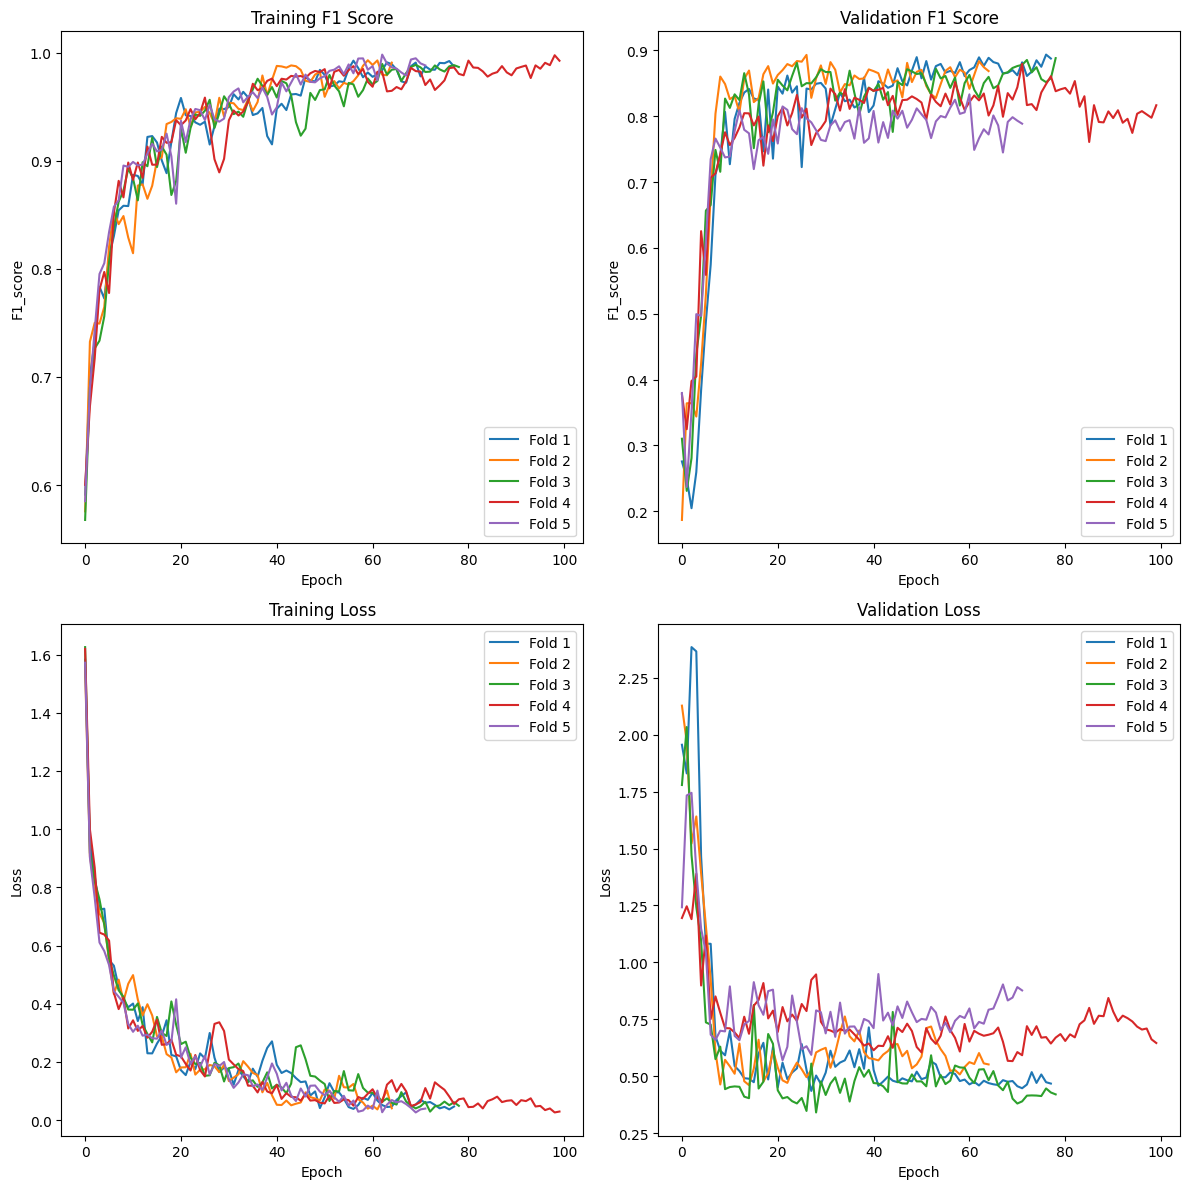

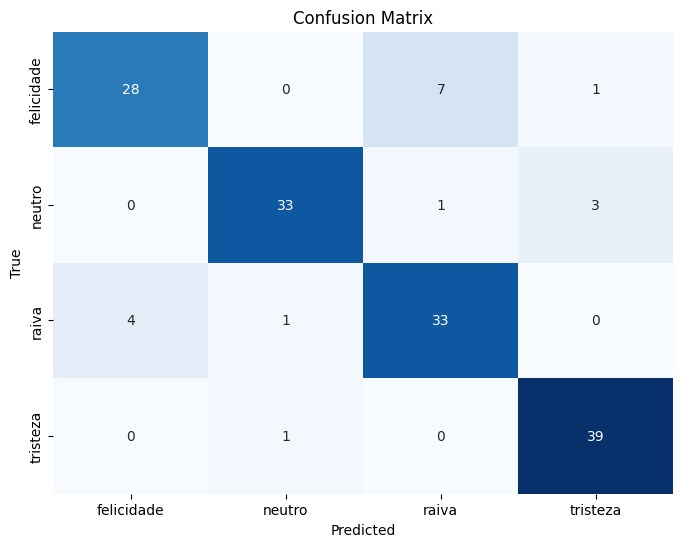

In [52]:
os.makedirs(result_folder, exist_ok=True)
best_model.save(f'{result_folder}best_model_fold{best_fold}.keras')

print(f"Best f1_score in fold {best_fold}: {best_f1_score}")
final_values = []

# Plot training and validation f1_score and loss
plt.figure(figsize=(12, 12))
for i, history in enumerate(all_histories):
    
    fold_data = {
        'Fold': i + 1,
        'Final Train Loss': history.history['loss'][-1],
        'Final Validation Loss': history.history['val_loss'][-1],
        'Final Train F1 Score': history.history['f1_metric'][-1],
        'Final Validation F1 Score': history.history['val_f1_metric'][-1],
    }
    final_values.append(fold_data)
    
    plt.subplot(2, 2, 1)
    plt.plot(history.history['f1_metric'], label=f'Fold {i+1}')
    plt.title('Training F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1_score')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history['val_f1_metric'], label=f'Fold {i+1}')
    plt.title('Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1_score')
    plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(history.history['loss'], label=f'Fold {i+1}')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(history.history['val_loss'], label=f'Fold {i+1}')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(result_folder, f'f1_and_losses_plot.png'))
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(best_conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=text_labels, yticklabels=text_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(result_folder, f'confusion_matrix.png'))
plt.show()

# Save to CSV file
csv_file_path = os.path.join(result_folder, 'final_values.csv')
fieldnames = ['Fold', 'Final Train Loss', 'Final Validation Loss', 'Final Train F1 Score', 'Final Validation F1 Score']

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    
    # Write header
    writer.writeheader()
    
    # Write data for each fold
    for fold_data in final_values:
        writer.writerow(fold_data)